In [1]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from urllib.request import urlopen
from PIL import Image
from torchvision import transforms
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset, random_split
import pandas as pd


/rds/general/user/ms7024/home/anaconda3/envs/breakhis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This function was then run on full (not toy) data in a separate .py script which was submitted as an array job. The results of this are tried below.

# Performance check: gradual unfreezing for binary classification

In [3]:
# Fuse the outputs of the long-run function together

models = ['HeadOnly', 'Stage_4', 'Stages_3-4', 'Stages_2-4', 'Stages_1-4']

for m in models:
    if m == 'HeadOnly':
        perf_train = pd.read_csv(f'convnext_v2_outputs/array_job_output/{m}_train.csv', index_col='Unnamed: 0')
    else:
        df = pd.read_csv(f'convnext_v2_outputs/array_job_output/{m}_train.csv', index_col='Unnamed: 0')
        perf_train = pd.concat([perf_train, df], axis=1)

for m in models:
    if m == 'HeadOnly':
        perf_test = pd.read_csv(f'convnext_v2_outputs/array_job_output/{m}_test.csv', index_col='Unnamed: 0')
    else:
        df = pd.read_csv(f'convnext_v2_outputs/array_job_output/{m}_test.csv', index_col='Unnamed: 0')
        perf_test = pd.concat([perf_test, df], axis=1)

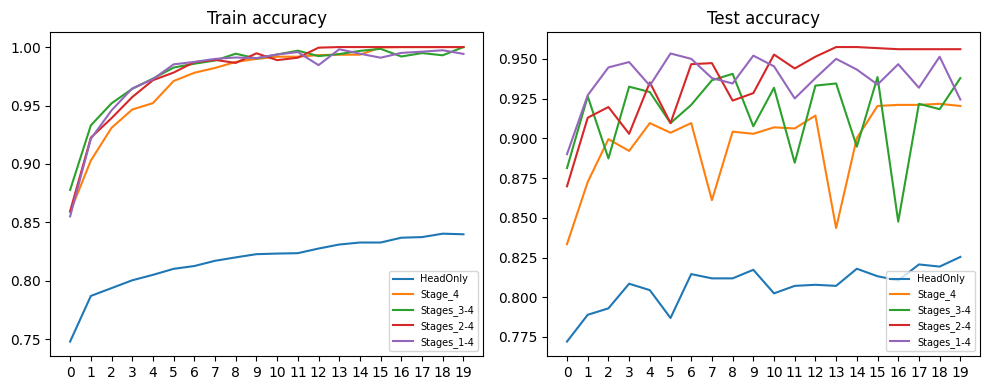

In [8]:
# Plot the result

import matplotlib.pyplot as plt

f, ax = plt.subplots(nrows = 1, ncols=2, figsize = (10, 4))

for i, df in enumerate([perf_train, perf_test]):
    
    for col in df.columns:
        ax[i].plot(range(perf_test.shape[0]), df.loc[:, col], label = col)
    
    if i == 0:
        ax[i].set_title("Train accuracy")
    else:
        ax[i].set_title("Test accuracy")
    
    ax[i].legend(prop={'size': 7})
    ax[i].set_xticks(range(20))

plt.tight_layout()
plt.savefig("unfreeze_accuracy.png") 
plt.show()

(OLD NOTE - does not refer to the figure above, but rather the previous iteration of the figure) This is the performance of the model after training on full data, for 20 epochs, with different levels "unfrozen" => hence, different experiments. The flat test performance of the last two experiments suggests that the learning rate is too high, forcing the model to "unlearn" the features and just predict the majority class. This will be fixed by changing learning rate to 1e-4; and potentially using different learning rates for different layers of the model. 

# Multi-class classification

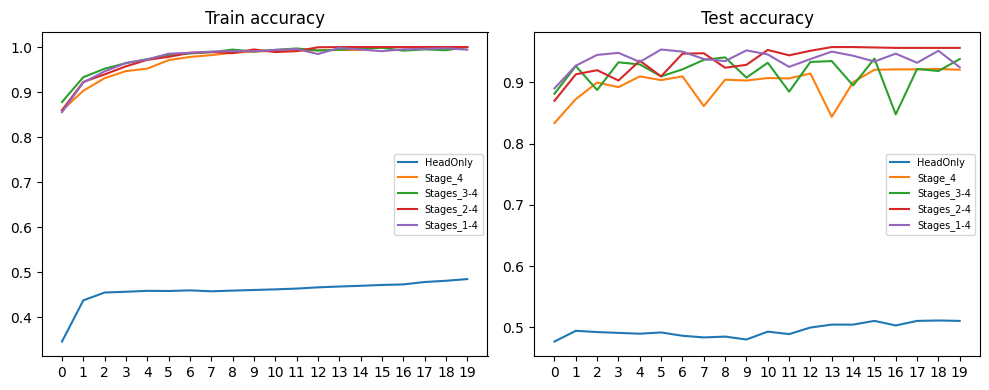

In [3]:
# Fuse the outputs of the long-run function together
import pandas as pd
import matplotlib.pyplot as plt

models = ['HeadOnly', 'Stage_4', 'Stages_3-4', 'Stages_2-4', 'Stages_1-4']

for m in models:
    if m == 'HeadOnly':
        perf_train = pd.read_csv(f'convnext_v2_outputs/array_job_output_multiclass/{m}_train.csv', index_col='Unnamed: 0')
    else:
        df = pd.read_csv(f'convnext_v2_outputs/array_job_output/{m}_train.csv', index_col='Unnamed: 0')
        perf_train = pd.concat([perf_train, df], axis=1)

for m in models:
    if m == 'HeadOnly':
        perf_test = pd.read_csv(f'convnext_v2_outputs/array_job_output_multiclass/{m}_test.csv', index_col='Unnamed: 0')
    else:
        df = pd.read_csv(f'convnext_v2_outputs/array_job_output/{m}_test.csv', index_col='Unnamed: 0')
        perf_test = pd.concat([perf_test, df], axis=1)



f, ax = plt.subplots(nrows = 1, ncols=2, figsize = (10, 4))

for i, df in enumerate([perf_train, perf_test]):
    
    for col in df.columns:
        ax[i].plot(range(perf_test.shape[0]), df.loc[:, col], label = col)
    
    if i == 0:
        ax[i].set_title("Train accuracy")
    else:
        ax[i].set_title("Test accuracy")
    
    ax[i].legend(prop={'size': 7})
    ax[i].set_xticks(range(20))

plt.tight_layout()
plt.savefig("unfreeze_accuracy.png") 
plt.show()

# Hyperparameter tuning for binary

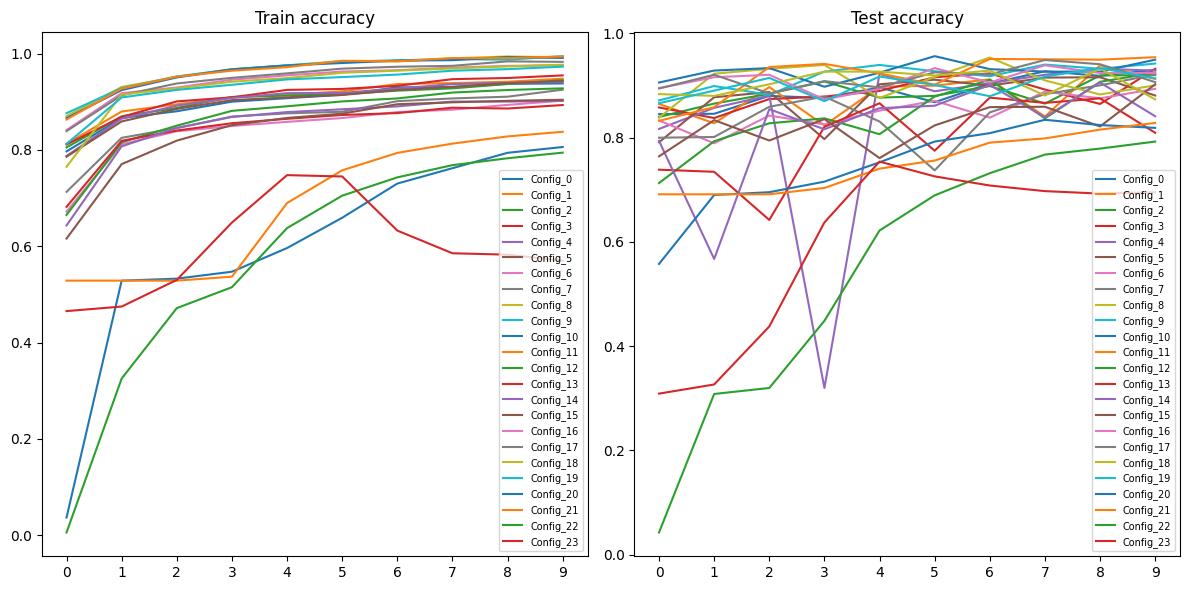

In [48]:
# Fuse the outputs of the long-run function together
import pandas as pd
import matplotlib.pyplot as plt

folder =  "array_job_output_HPO"

for m in range(1, 25):
    if m == 1:
        perf_train = pd.read_csv(f'convnext_v2_outputs/{folder}/Config{m}_train.csv', index_col='Unnamed: 0')
    else:
        df = pd.read_csv(f'convnext_v2_outputs/{folder}/Config{m}_train.csv', index_col='Unnamed: 0')
        perf_train = pd.concat([perf_train, df], axis=1)

for m in range(1, 25):
    if m == 1:
        perf_test = pd.read_csv(f'convnext_v2_outputs/{folder}/Config{m}_test.csv', index_col='Unnamed: 0')
    else:
        df = pd.read_csv(f'convnext_v2_outputs/{folder}/Config{m}_test.csv', index_col='Unnamed: 0')
        perf_test = pd.concat([perf_test, df], axis=1)


f, ax = plt.subplots(nrows = 1, ncols=2, figsize = (12, 6))

for i, df in enumerate([perf_train, perf_test]):
    
    for col in df.columns:
        ax[i].plot(range(perf_test.shape[0]), df.loc[:, col], label = col)
    
    if i == 0:
        ax[i].set_title("Train accuracy")
    else:
        ax[i].set_title("Test accuracy")
    
    ax[i].legend(prop={'size': 7})
    ax[i].set_xticks(range(10))

plt.tight_layout()
plt.savefig("unfreeze_accuracy.png") 
plt.show()

### Results table
Creating a table which, for each parameter configuration, disaplays the best accuracy and the epoch at which it occurred. 

In [33]:
import itertools
hyperparams = {
    'lr': [1e-3, 1e-4, 1e-5],
    'optimizer': ['adam', 'sgd'],
    'batch_size': [16, 32],
    'weight_decay': [0, 1e-4]}

keys = hyperparams.keys()
values = hyperparams.values()
all_configs = []
for prod in itertools.product(*values): # Make all combinations of parameters
    config = dict(zip(keys, prod))
    all_configs.append(config)

cols = ['Config', 'Best Validation Accuracy', 'Epoch', 'Hyperparams']
best_perf = pd.DataFrame(index = range(len(all_configs)), columns = cols)

best_perf['Config'] = perf_test.columns
best_perf['Best Validation Accuracy'] = list(perf_test.max(axis=0) )   
best_perf['Epoch'] = list(perf_test.idxmax(axis=0))
best_perf['Hyperparams'] = all_configs

top_idx = best_perf['Best Validation Accuracy'].idxmax()
print(f"Best performance: {best_perf.iloc[top_idx,0]}\
      with accuracy of {best_perf.iloc[top_idx,1]} in epoch {best_perf.iloc[top_idx,2]}")
best_perf.iloc[top_idx,3]

Best performance: Config_10      with accuracy of 0.9561699258260284 in epoch 5


{'lr': 0.0001, 'optimizer': 'adam', 'batch_size': 32, 'weight_decay': 0}

In [42]:
# Top three configurations by validation accuracy

best_idx = list(best_perf.nlargest(3, 'Best Validation Accuracy').index)
best_perf.nlargest(3, 'Best Validation Accuracy')

,Config,Best Validation Accuracy,Epoch,Hyperparams
10,Config_10,0.956170,5,"{'lr': 0.0001, 'optimizer': 'adam', 'batch_siz..."
11,Config_11,0.954147,9,"{'lr': 0.0001, 'optimizer': 'adam', 'batch_siz..."
8,Config_8,0.953473,6,"{'lr': 0.0001, 'optimizer': 'adam', 'batch_siz..."


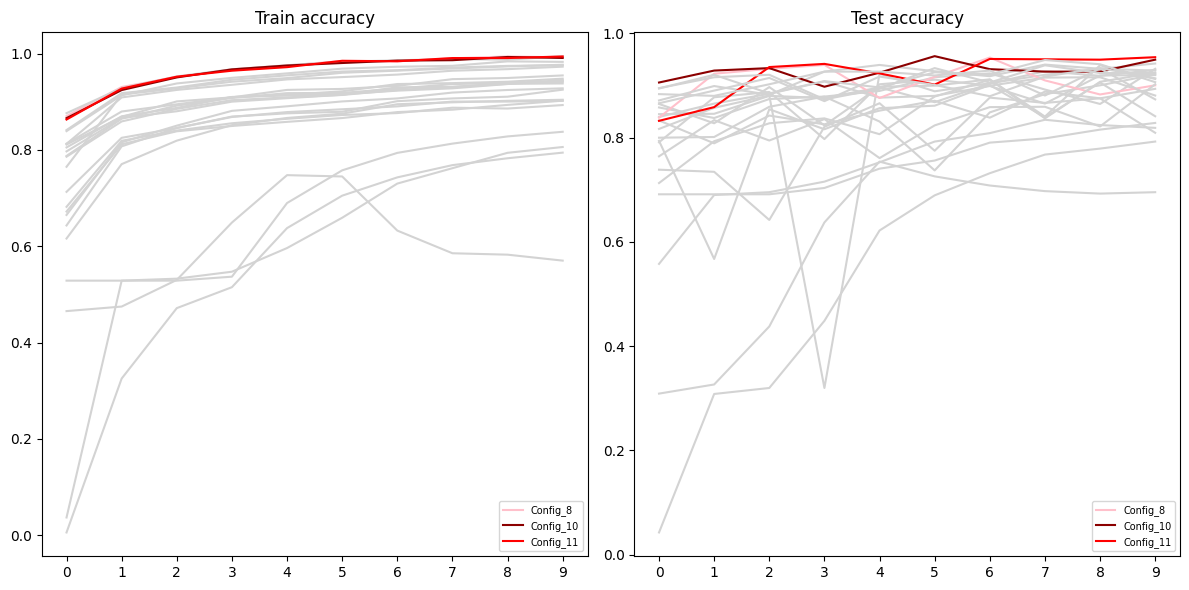

In [68]:
f, ax = plt.subplots(nrows = 1, ncols=2, figsize = (12, 6))

colors = ['darkred', 'red', '#ff3333']
best_col = list(df.columns[best_idx])

for i, df in enumerate([perf_train, perf_test]):
    
    for col in df.columns:
        if any(col == top_col for top_col in best_col):
            ax[i].plot(range(perf_test.shape[0]), df.loc[:, col], label = col, color=colrs[best_col.index(col)])
        else:
            ax[i].plot(range(perf_test.shape[0]), df.loc[:, col], color='lightgray')
    if i == 0:
        ax[i].set_title("Train accuracy")
    else:
        ax[i].set_title("Test accuracy")
    
    ax[i].legend(prop={'size': 7})
    ax[i].set_xticks(range(10))

plt.tight_layout()
plt.show()

Config_8 is the worst of three, with the most 'noisy' test performance. Between Config 10 and 11, it looks like Config_11 is closer to levelling off, whereas Config_10 may still have some increase; it is also the best one. This is the configuration we will go with, with the following hyperparameters:


In [75]:
best_perf.iloc[10,3]

{'lr': 0.0001, 'optimizer': 'adam', 'batch_size': 32, 'weight_decay': 0}